In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.feature_selection import mutual_info_classif,chi2
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import roc_auc_score, mean_squared_error

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import CondensedNearestNeighbour

import category_encoders as ce

Using TensorFlow backend.


___
### Data source: https://archive.ics.uci.edu/ml/datasets/Adult   

### Из описания:  
> ### <font color=red>The instance weight indicates the number of people in the population that each record represents due to stratified sampling. This attribute should *not* be used in the classifiers.</font>

### Т.е. параметр fnlwgt из рассмотрения исключаем.
___

In [2]:
data_file_name = 'adult.data'
data_header = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status',
               'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss',
               'hours-per-week', 'native-country', 'income']
data_frame = pd.read_csv(data_file_name, names = data_header, header=None, index_col=False).drop('fnlwgt', axis=1)

In [3]:
data_frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 14 columns):
age               32561 non-null int64
workclass         32561 non-null object
education         32561 non-null object
education-num     32561 non-null int64
marital-status    32561 non-null object
occupation        32561 non-null object
relationship      32561 non-null object
race              32561 non-null object
sex               32561 non-null object
capital-gain      32561 non-null int64
capital-loss      32561 non-null int64
hours-per-week    32561 non-null int64
native-country    32561 non-null object
income            32561 non-null object
dtypes: int64(5), object(9)
memory usage: 3.5+ MB


In [4]:
data_frame.head(10)

,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
5,37,Private,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K
6,49,Private,9th,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16,Jamaica,<=50K
7,52,Self-emp-not-inc,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,>50K
8,31,Private,Masters,14,Never-married,Prof-specialty,Not-in-family,White,Female,14084,0,50,United-States,>50K
9,42,Private,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178,0,40,United-States,>50K


In [5]:
def check_missing(data):    
    result = pd.concat([data.isnull().sum(),data.isnull().mean()],axis=1)
    result = result.rename(index=str,columns={0:'total',1:'relative'})    
    return result

In [6]:
check_missing(data_frame)

,total,relative
age,0,0.0
workclass,0,0.0
education,0,0.0
education-num,0,0.0
marital-status,0,0.0
occupation,0,0.0
relationship,0,0.0
race,0,0.0
sex,0,0.0
capital-gain,0,0.0


___
## Пропущенных данных нет. Посмотрим на распределения параметров, проверим, есть ли "выбросы".
___

In [7]:
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000075924726A0>,
      dtype=object)

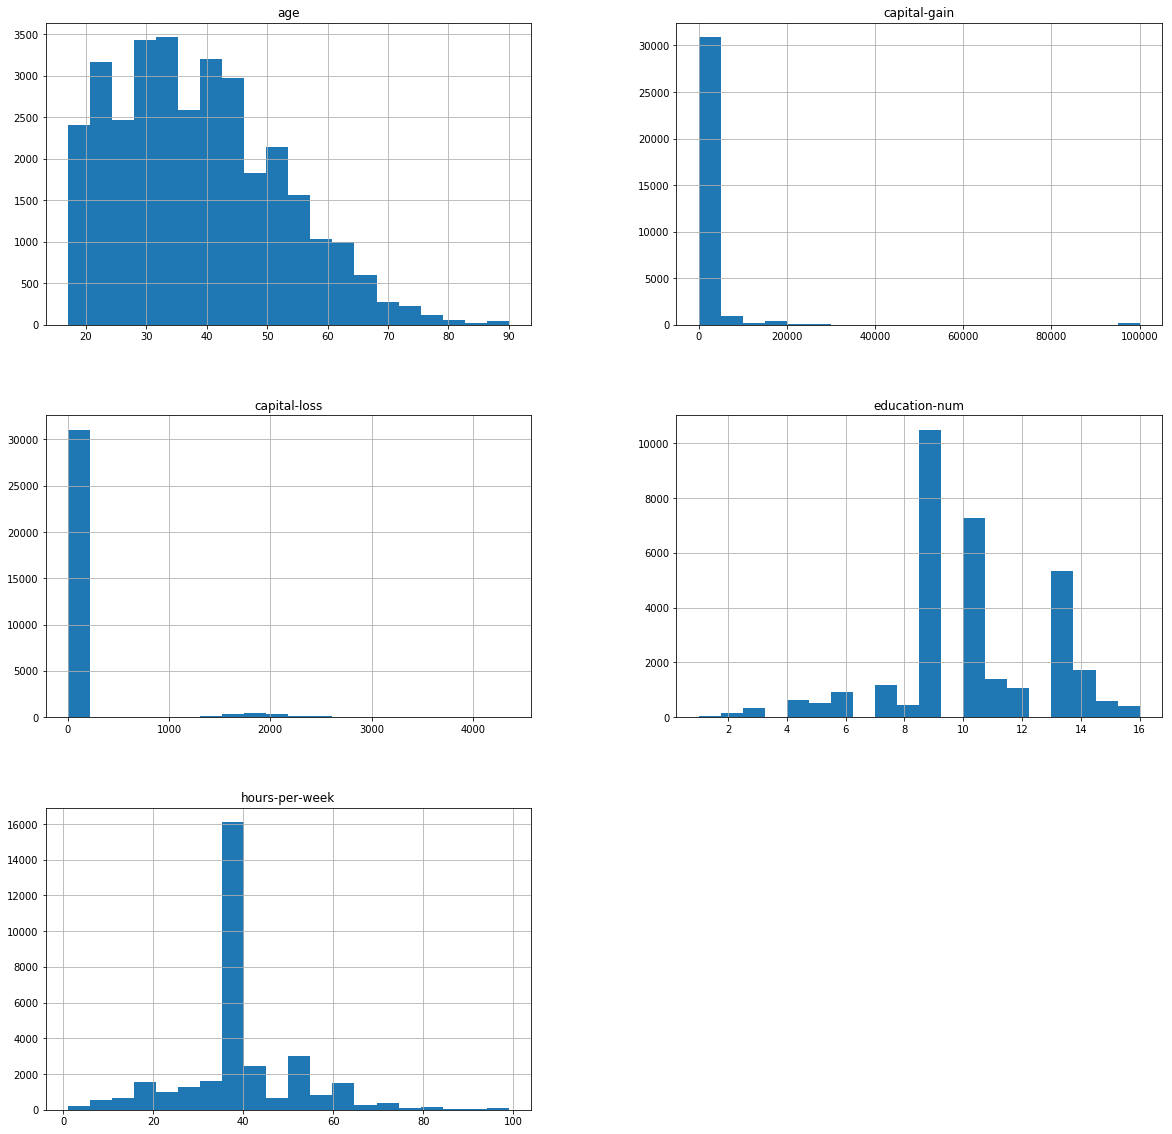

In [8]:
data_frame[numerical].hist(bins=20, figsize=(20, 20))

___
## В распределениях двух параметров - capital-loss и capital-gain наблюдаются "выбросы".  
## Оценим их долю в общем количестве...
___

In [9]:
def outlier_detect_arbitrary(data,col,upper_fence,lower_fence):
    para = (upper_fence, lower_fence)
    tmp = pd.concat([data[col]>upper_fence,data[col]<lower_fence],axis=1)
    outlier_index = tmp.any(axis=1)
    print('Количество выбросов в данных:',outlier_index.value_counts()[1])
    print('Доля выбросов:',outlier_index.value_counts()[1]/len(outlier_index))    
    return outlier_index, para

In [10]:
index,para = outlier_detect_arbitrary(data=data_frame,col='capital-loss',upper_fence=2500,lower_fence=0)
print('Верхняя граница:',para[0],'\nНижняя граница:',para[1])

Количество выбросов в данных: 44
Доля выбросов: 0.0013513098492061054
Верхняя граница: 2500 
Нижняя граница: 0


In [11]:
index,para = outlier_detect_arbitrary(data=data_frame,col='capital-gain',upper_fence=3000,lower_fence=0)
print('Верхняя граница:',para[0],'\nНижняя граница:',para[1])

Количество выбросов в данных: 2240
Доля выбросов: 0.06879395595958356
Верхняя граница: 3000 
Нижняя граница: 0


In [12]:
def outlier_detect_IQR(data,col,threshold=3):    
    IQR = data[col].quantile(0.75) - data[col].quantile(0.25)
    Lower_fence = data[col].quantile(0.25) - (IQR * threshold)
    Upper_fence = data[col].quantile(0.75) + (IQR * threshold)
    para = (Upper_fence, Lower_fence)
    tmp = pd.concat([data[col]>Upper_fence,data[col]<Lower_fence],axis=1)
    outlier_index = tmp.any(axis=1)
    print('Количество выбросов в данных:',outlier_index.value_counts()[1])
    print('Доля выбросов:',outlier_index.value_counts()[1]/len(outlier_index))
    return outlier_index, para

In [13]:
index,para = outlier_detect_IQR(data=data_frame,col='capital-loss', threshold=3)
print('Верхняя граница:',para[0],'\nНижняя граница:',para[1])

Количество выбросов в данных: 1519
Доля выбросов: 0.0466509013850926
Верхняя граница: 0.0 
Нижняя граница: 0.0


In [14]:
index,para = outlier_detect_IQR(data=data_frame,col='capital-gain', threshold=3)
print('Верхняя граница:',para[0],'\nНижняя граница:',para[1])

Количество выбросов в данных: 2712
Доля выбросов: 0.08328982525106723
Верхняя граница: 0.0 
Нижняя граница: 0.0


In [15]:
data_frame['capital-loss'].describe()

count    32561.000000
mean        87.303830
std        402.960219
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max       4356.000000
Name: capital-loss, dtype: float64

In [16]:
data_frame['capital-loss'].value_counts()[0:10]

0       31042
1902      202
1977      168
1887      159
1848       51
1485       51
2415       49
1602       47
1740       42
1590       40
Name: capital-loss, dtype: int64

In [17]:
data_frame['capital-gain'].describe()

count    32561.000000
mean      1077.648844
std       7385.292085
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      99999.000000
Name: capital-gain, dtype: float64

In [18]:
data_frame['capital-gain'].value_counts()[0:10]

0        29849
15024      347
7688       284
7298       246
99999      159
5178        97
3103        97
4386        70
5013        69
8614        55
Name: capital-gain, dtype: int64

___
### Параметры capital-loss и capital-gain в явном видепредставляются неинформативными: примерно 30000 значений из общего количества 32000 имеют нулевое значение. Они обозначают доход из источников, не связанных с основным видом деятельности (нарпример, вложения в ценные бумаги, выигрыши в лотерею и т.п.).  
### Предлагается просто ввести индикатор  есть/нет доход(убыток) от неосновной деятельности.  
### Посмотрим, как распределены по уровню дохода те, кто имеет и не имеет дополнительных источников дохода. 
___

In [19]:
df_selection = data_frame[['capital-loss', 'capital-gain', 'income']]
df_selection['capital-loss'] = df_selection['capital-loss'].apply(lambda x: 0 if x==0 else 1)
df_selection['capital-gain'] = df_selection['capital-gain'].apply(lambda x: 0 if x==0 else 1)

C:\Users\Supervisor\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Supervisor\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


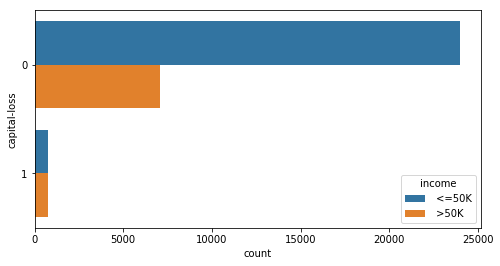

In [20]:
plt.subplots(figsize=(8,4))
sns.countplot(y='capital-loss', hue='income', data=df_selection)

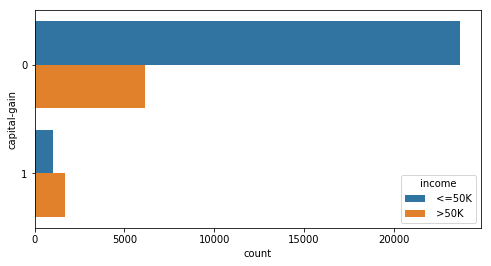

In [21]:
plt.subplots(figsize=(8,4))
sns.countplot(y='capital-gain', hue='income', data=df_selection)

___
### Такое представление более информативно: 
- ### получается, что среди тех, кто не имеет дополнительных сочников дохода намного больше тех, у кого годовой доход менье $50000,  
- ### и наоборот, среди имеющих дополнительные источники дохода больше тех, у кого высокий годовой доход
___

In [22]:
def impute_outlier_with_arbitrary(data,outlier_index,value,col=[]):
    data_copy = data.copy(deep=True)
    for i in col:
        data_copy.loc[outlier_index,i] = value
    return data_copy

___
### Для параметров capital-gain и capital-loss совместим кодирование и замены "выбросов":  
___

In [23]:
index_loss,para_loss = outlier_detect_arbitrary(data=data_frame,col='capital-loss',upper_fence=0,lower_fence=0)
print('Верхняя граница:',para[0],'\nНижняя граница:',para[1])

Количество выбросов в данных: 1519
Доля выбросов: 0.0466509013850926
Верхняя граница: 0.0 
Нижняя граница: 0.0


In [24]:
index_gain,para_gain = outlier_detect_arbitrary(data=data_frame,col='capital-gain',upper_fence=0,lower_fence=0)
print('Верхняя граница:',para[0],'\nНижняя граница:',para[1])

Количество выбросов в данных: 2712
Доля выбросов: 0.08328982525106723
Верхняя граница: 0.0 
Нижняя граница: 0.0


In [25]:
loss_encoded = impute_outlier_with_arbitrary(data=data_frame,outlier_index=index_loss,
                                             value=1,col=['capital-loss'])
loss_encoded.describe()

,age,education-num,capital-gain,capital-loss,hours-per-week
count,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,10.080679,1077.648844,0.046651,40.437456
std,13.640433,2.572720,7385.292085,0.210893,12.347429
min,17.000000,1.000000,0.000000,0.000000,1.000000
25%,28.000000,9.000000,0.000000,0.000000,40.000000
50%,37.000000,10.000000,0.000000,0.000000,40.000000
75%,48.000000,12.000000,0.000000,0.000000,45.000000
max,90.000000,16.000000,99999.000000,1.000000,99.000000


In [26]:
gain_loss_encoded = impute_outlier_with_arbitrary(data=loss_encoded,outlier_index=index_gain,
                                                  value=1,col=['capital-gain'])
gain_loss_encoded.describe()

,age,education-num,capital-gain,capital-loss,hours-per-week
count,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,10.080679,0.083290,0.046651,40.437456
std,13.640433,2.572720,0.276324,0.210893,12.347429
min,17.000000,1.000000,0.000000,0.000000,1.000000
25%,28.000000,9.000000,0.000000,0.000000,40.000000
50%,37.000000,10.000000,0.000000,0.000000,40.000000
75%,48.000000,12.000000,0.000000,0.000000,45.000000
max,90.000000,16.000000,1.000000,1.000000,99.000000


In [27]:
def outlier_detect_mean_std(data,col,threshold=3):
    Upper_fence = data[col].mean() + threshold * data[col].std()
    Lower_fence = data[col].mean() - threshold * data[col].std()   
    para = (Upper_fence, Lower_fence)   
    tmp = pd.concat([data[col]>Upper_fence,data[col]<Lower_fence],axis=1)
    outlier_index = tmp.any(axis=1)
    print('Количество выбросов в данных:',outlier_index.value_counts()[1])
    print('Доля выбросов:',outlier_index.value_counts()[1]/len(outlier_index))
    return outlier_index, para

In [28]:
outlier_detect_mean_std(data_frame, 'hours-per-week', 3);

Количество выбросов в данных: 440
Доля выбросов: 0.013513098492061055


In [29]:
def outlier_detect_MAD(data,col,threshold=3.5):
    median = data[col].median()
    median_absolute_deviation = np.median([np.abs(y - median) for y in data[col]])
    modified_z_scores = pd.Series([0.6745 * (y - median) / median_absolute_deviation for y in data[col]])
    outlier_index = np.abs(modified_z_scores) > threshold
    print('Количество выбросов в данных:',outlier_index.value_counts()[1])
    print('Доля выбросов:',outlier_index.value_counts()[1]/len(outlier_index))
    return outlier_index

In [30]:
outlier_index = outlier_detect_MAD(data_frame, 'hours-per-week', 3.5)

Количество выбросов в данных: 6001
Доля выбросов: 0.1843002364792236


In [31]:
data_frame['education'].nunique()

16

In [32]:
data_frame['education-num'].nunique()

16

In [33]:
education_encoded = ce.OrdinalEncoder(cols=['education']).fit_transform(data_frame)['education']

In [34]:
education_encoded.nunique()

16

___
### Параметр education-num дублирует параметр education, т.к. означает общее количество лет, потраченных на образование, но предтсавляется более информативным для модели классификации. Параметр education можно отбросить.  
___

In [35]:
data_frame = data_frame.drop(['education'], axis=1)

In [36]:
continuous = ['age', 'hours-per-week', 'education-num']

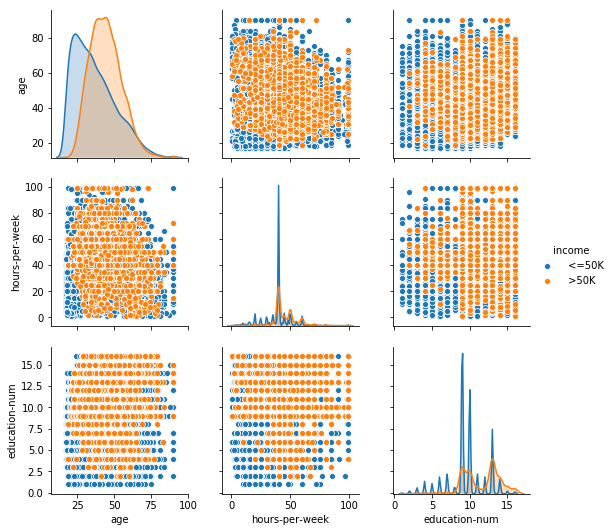

In [37]:
sns.pairplot(data=data_frame, vars=continuous, hue='income')

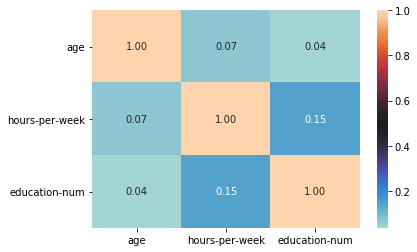

In [38]:
sns.heatmap(data=data_frame[continuous].corr(),  annot=True, fmt='.2f', center = 0.5)

___
### Сколько-нибудь значимой корреляции между численными параметрами не выявлено.  
### Выраженные различия для разных доходов показал только параметр age: люди с большим доходом, в среднем, старше.  
___

___
## Масштабирование данных  
___

In [39]:
X_train, X_test, y_train, y_test = train_test_split(data_frame.drop(labels='income', axis=1), data_frame.income, test_size=0.3,
                                                    random_state=1812)
X_train.shape, X_test.shape

((22792, 12), (9769, 12))

In [40]:
data_frame['hours-per-week'].value_counts(normalize=True, sort='ascending')[0:7]

40    0.467338
50    0.086576
45    0.056018
60    0.045300
35    0.039833
20    0.037591
30    0.035288
Name: hours-per-week, dtype: float64

___
### Для масштабирования предлагается такой подход для сохранения интерпретируемости отмасштабированных значений:  
- ### параметр age нормируем к диапазону [0;1] - чем старше человек, тем больше параметр,
- ### параметр education-num нормируем к диапазону [0;1] - чем больше параметр, тем дольше человек занимался образованем,
- ### параметр hours-per-week имеет моду - 40 часов, приведём среднее значению к 0, дисперсию - к 1, параметр будет означать отклонение от "нормального" значения в 40 часов

___

In [41]:
standard_scaler = StandardScaler().fit(X_train[['hours-per-week']])

In [42]:
X_train['hours-per-week'] = standard_scaler.transform(X_train[['hours-per-week']])
X_train['hours-per-week'].describe()

count    2.279200e+04
mean    -2.194386e-16
std      1.000022e+00
min     -3.186480e+00
25%     -3.859391e-02
50%     -3.859391e-02
75%      3.649813e-01
max      4.723593e+00
Name: hours-per-week, dtype: float64

In [43]:
X_test['hours-per-week'] = standard_scaler.transform(X_test[['hours-per-week']])
X_test['hours-per-week'].describe()

count    9769.000000
mean       -0.010948
std         0.988656
min        -3.186480
25%        -0.038594
50%        -0.038594
75%         0.364981
max         4.723593
Name: hours-per-week, dtype: float64

In [44]:
min_max_scaler = MinMaxScaler().fit(X_train[['age']])

In [45]:
print(min_max_scaler.data_max_)

[90.]


In [46]:
X_train['age'] = min_max_scaler.transform(X_train[['age']])
X_train['age'].describe()

count    22792.000000
mean         0.296007
std          0.187105
min          0.000000
25%          0.150685
50%          0.273973
75%          0.424658
max          1.000000
Name: age, dtype: float64

In [47]:
X_test['age'] = min_max_scaler.transform(X_test[['age']])
X_test['age'].describe()

count    9769.000000
mean        0.294779
std         0.186278
min         0.000000
25%         0.150685
50%         0.273973
75%         0.410959
max         1.000000
Name: age, dtype: float64

In [48]:
min_max_scaler = MinMaxScaler().fit(X_train[['education-num']])
print(min_max_scaler.data_max_)

[16.]


In [49]:
X_train['education-num'] = min_max_scaler.transform(X_train[['education-num']])
X_train['education-num'].describe()

count    22792.000000
mean         0.605961
std          0.171696
min          0.000000
25%          0.533333
50%          0.600000
75%          0.800000
max          1.000000
Name: education-num, dtype: float64

In [50]:
X_test['education-num'] = min_max_scaler.transform(X_test[['education-num']])
X_test['education-num'].describe()

count    9769.000000
mean        0.604020
std         0.171093
min         0.000000
25%         0.533333
50%         0.600000
75%         0.733333
max         1.000000
Name: education-num, dtype: float64

___
## Кодирование категориальных параметров  
___

In [51]:
categorical = ['workclass', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']

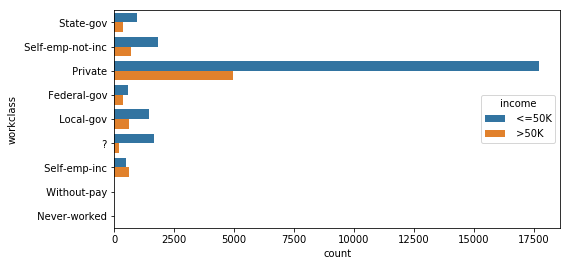

In [52]:
plt.subplots(figsize=(8,4))
sns.countplot(y='workclass', hue='income', data=data_frame)

In [53]:
data1 = pd.get_dummies(data_frame,drop_first=True)
len(data1.columns)

85

In [54]:
data1 = pd.get_dummies(data_frame['workclass'],drop_first=True)
data1.head(10)

,Federal-gov,Local-gov,Never-worked,Private,Self-emp-inc,Self-emp-not-inc,State-gov,Without-pay
0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,1,0,0
2,0,0,0,1,0,0,0,0
3,0,0,0,1,0,0,0,0
4,0,0,0,1,0,0,0,0
5,0,0,0,1,0,0,0,0
6,0,0,0,1,0,0,0,0
7,0,0,0,0,0,1,0,0
8,0,0,0,1,0,0,0,0
9,0,0,0,1,0,0,0,0


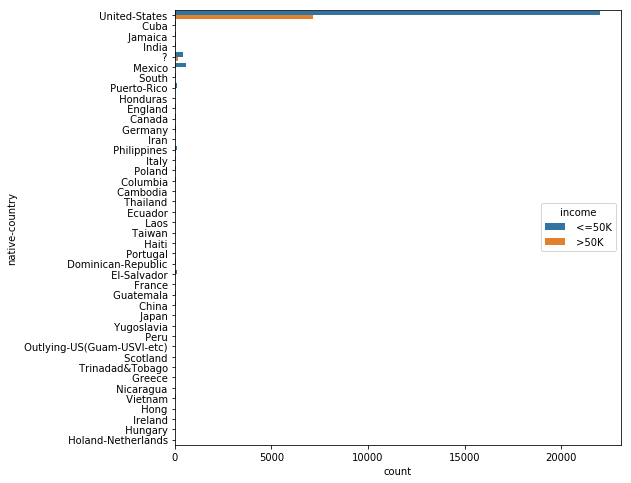

In [55]:
plt.subplots(figsize=(8,8))
sns.countplot(y='native-country', hue='income', data=data_frame)

In [56]:
data_frame['native-country'].value_counts()

 United-States                 29170
 Mexico                          643
 ?                               583
 Philippines                     198
 Germany                         137
 Canada                          121
 Puerto-Rico                     114
 El-Salvador                     106
 India                           100
 Cuba                             95
 England                          90
 Jamaica                          81
 South                            80
 China                            75
 Italy                            73
 Dominican-Republic               70
 Vietnam                          67
 Guatemala                        64
 Japan                            62
 Poland                           60
 Columbia                         59
 Taiwan                           51
 Haiti                            44
 Iran                             43
 Portugal                         37
 Nicaragua                        34
 Peru                             31
 

___
### Для параметра native-country целесообразно бинарное кодирование United States / other: слишком много различных значений с минимальной долей содержащих записей   
___

In [57]:
df_copy = data_frame.copy(deep=True)

In [58]:
df_copy['native-country'] = df_copy['native-country'].apply(lambda x: 1 if x==' United-States' else 0)

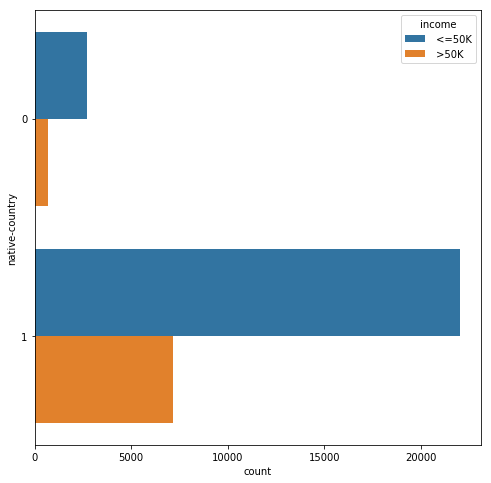

In [59]:
plt.subplots(figsize=(8,8))
sns.countplot(y='native-country', hue='income', data=df_copy)

In [60]:
df_copy['native-country'].value_counts()

1    29170
0     3391
Name: native-country, dtype: int64

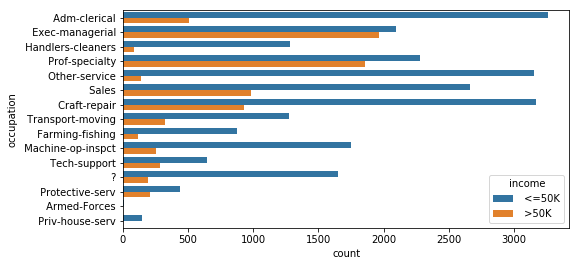

In [61]:
plt.subplots(figsize=(8,4))
sns.countplot(y='occupation', hue='income', data=data_frame)

In [62]:
ord_enc = ce.OrdinalEncoder(cols=['occupation']).fit(X_train)

In [63]:
data1 = ord_enc.transform(X_train)
data1.head(10)

,age,workclass,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
26036,0.287671,Self-emp-not-inc,0.533333,Divorced,1,Own-child,White,Male,0,0,0.768556,United-States
7884,0.356164,Private,0.533333,Married-civ-spouse,2,Husband,White,Male,0,0,-0.038594,United-States
11847,0.246575,Local-gov,0.866667,Never-married,3,Not-in-family,White,Male,0,0,1.575707,United-States
22201,0.136986,Private,0.533333,Married-civ-spouse,4,Husband,White,Male,0,0,-0.038594,Mexico
25088,0.164384,Federal-gov,0.800000,Married-civ-spouse,5,Husband,White,Male,7688,0,-0.038594,United-States
7321,0.041096,Private,0.200000,Never-married,4,Other-relative,White,Male,0,0,-0.038594,United-States
14579,0.520548,Private,0.866667,Married-civ-spouse,5,Husband,White,Male,99999,0,1.172132,United-States
17276,0.054795,Private,0.333333,Married-civ-spouse,2,Husband,White,Male,0,0,-0.038594,United-States
11516,0.013699,?,0.466667,Never-married,6,Own-child,Other,Male,0,0,-0.038594,United-States
20585,0.410959,Private,0.533333,Divorced,7,Not-in-family,Black,Female,0,0,-2.137185,United-States


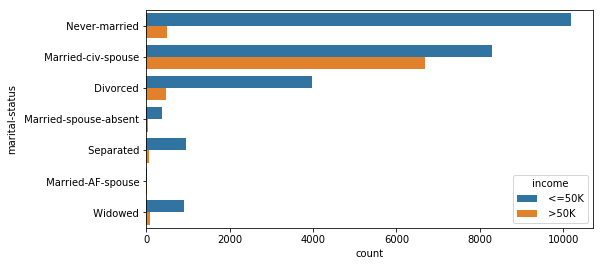

In [64]:
plt.subplots(figsize=(8,4))
sns.countplot(y='marital-status', hue='income', data=data_frame)

In [65]:
data1 = pd.get_dummies(data=data_frame, columns=['marital-status'],drop_first=True)
data1.head(10)

,age,workclass,education-num,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income,marital-status_ Married-AF-spouse,marital-status_ Married-civ-spouse,marital-status_ Married-spouse-absent,marital-status_ Never-married,marital-status_ Separated,marital-status_ Widowed
0,39,State-gov,13,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K,0,0,0,1,0,0
1,50,Self-emp-not-inc,13,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K,0,1,0,0,0,0
2,38,Private,9,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K,0,0,0,0,0,0
3,53,Private,7,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K,0,1,0,0,0,0
4,28,Private,13,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K,0,1,0,0,0,0
5,37,Private,14,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K,0,1,0,0,0,0
6,49,Private,5,Other-service,Not-in-family,Black,Female,0,0,16,Jamaica,<=50K,0,0,1,0,0,0
7,52,Self-emp-not-inc,9,Exec-managerial,Husband,White,Male,0,0,45,United-States,>50K,0,1,0,0,0,0
8,31,Private,14,Prof-specialty,Not-in-family,White,Female,14084,0,50,United-States,>50K,0,0,0,1,0,0
9,42,Private,13,Exec-managerial,Husband,White,Male,5178,0,40,United-States,>50K,0,1,0,0,0,0


___
## Feature selection
___

### Константный анализ   

In [66]:
def constant_feature_detect(data,threshold=0.98):    
    data_copy = data.copy(deep=True)
    quasi_constant_feature = []
    for feature in data_copy.columns:
        predominant = (data_copy[feature].value_counts() / np.float(
                      len(data_copy))).sort_values(ascending=False).values[0]
        if predominant >= threshold:
            quasi_constant_feature.append(feature)
    print(len(quasi_constant_feature),'константные переменные')    
    return quasi_constant_feature

In [67]:
quasi_constant_feature = constant_feature_detect(data=X_train,threshold=0.9)

2 константные переменные


In [68]:
quasi_constant_feature

['capital-gain', 'capital-loss']

### Одномерный ROC-AUC или MSE анализ  

In [69]:
data_frame['capital-loss'] = data_frame['capital-loss'].apply(lambda x: 0 if x==0 else 1)
data_frame['capital-gain'] = data_frame['capital-gain'].apply(lambda x: 0 if x==0 else 1)
data_frame['native-country'] = data_frame['native-country'].apply(lambda x: 1 if x==' United-States' else 0)

ord_enc = ce.OrdinalEncoder(cols=['occupation']).fit(data_frame)
data_frame = ord_enc.transform(data_frame)

categorical = ['workclass', 'marital-status', 'relationship', 'race', 'sex']
data_frame = pd.get_dummies(data=data_frame, columns=categorical, drop_first=True)

data_frame['income'] = data_frame['income'].apply(lambda x: 1 if x==' >50K' else 0)

data_frame.head()

,age,education-num,occupation,capital-gain,capital-loss,hours-per-week,native-country,income,workclass_ Federal-gov,workclass_ Local-gov,...,relationship_ Not-in-family,relationship_ Other-relative,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,race_ Asian-Pac-Islander,race_ Black,race_ Other,race_ White,sex_ Male
0,39,13,1,1,0,40,1,0,0,0,...,1,0,0,0,0,0,0,0,1,1
1,50,13,2,0,0,13,1,0,0,0,...,0,0,0,0,0,0,0,0,1,1
2,38,9,3,0,0,40,1,0,0,0,...,1,0,0,0,0,0,0,0,1,1
3,53,7,3,0,0,40,1,0,0,0,...,0,0,0,0,0,0,1,0,0,1
4,28,13,4,0,0,40,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0


In [70]:
data_frame['income'][156]

0

In [71]:
X_train, X_test, y_train, y_test = train_test_split(data_frame.drop(labels='income', axis=1), data_frame.income, test_size=0.3,
                                                    random_state=1812)
X_train.shape, X_test.shape

((22792, 31), (9769, 31))

In [72]:
standard_scaler = StandardScaler().fit(X_train[['hours-per-week']])
X_train['hours-per-week'] = standard_scaler.transform(X_train[['hours-per-week']])
X_test['hours-per-week'] = standard_scaler.transform(X_test[['hours-per-week']])

In [73]:
min_max_scaler = MinMaxScaler().fit(X_train[['age']])
X_train['age'] = min_max_scaler.transform(X_train[['age']])
X_test['age'] = min_max_scaler.transform(X_test[['age']])

In [74]:
min_max_scaler = MinMaxScaler().fit(X_train[['education-num']])
X_train['education-num'] = min_max_scaler.transform(X_train[['education-num']])
X_test['education-num'] = min_max_scaler.transform(X_test[['education-num']])

In [75]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22792 entries, 26036 to 17755
Data columns (total 31 columns):
age                                      22792 non-null float64
education-num                            22792 non-null float64
occupation                               22792 non-null int32
capital-gain                             22792 non-null int64
capital-loss                             22792 non-null int64
hours-per-week                           22792 non-null float64
native-country                           22792 non-null int64
workclass_ Federal-gov                   22792 non-null uint8
workclass_ Local-gov                     22792 non-null uint8
workclass_ Never-worked                  22792 non-null uint8
workclass_ Private                       22792 non-null uint8
workclass_ Self-emp-inc                  22792 non-null uint8
workclass_ Self-emp-not-inc              22792 non-null uint8
workclass_ State-gov                     22792 non-null uint8
workclass_ Wi

In [76]:
def univariate_roc_auc(X_train,y_train,X_test,y_test,threshold):

    roc_values = []
    for feature in X_train.columns:
        clf = DecisionTreeClassifier()
        clf.fit(X_train[feature].to_frame(), y_train)
        y_scored = clf.predict_proba(X_test[feature].to_frame())
        roc_values.append(roc_auc_score(y_test, y_scored[:, 1]))
    roc_values = pd.Series(roc_values)
    roc_values.index = X_train.columns
    print(roc_values.sort_values(ascending=False))
    print(len(roc_values[roc_values > threshold]), len(X_train.columns))
    keep_col = roc_values[roc_values > threshold]
    return keep_col

In [77]:
uni_roc_auc = univariate_roc_auc(X_train=X_train,y_train=y_train,
                                 X_test=X_test,y_test=y_test,threshold=0.8)
print(uni_roc_auc)

marital-status_ Married-civ-spouse       0.763917
occupation                               0.731915
education-num                            0.718055
age                                      0.708671
marital-status_ Never-married            0.673910
hours-per-week                           0.664882
sex_ Male                                0.619145
relationship_ Own-child                  0.600824
relationship_ Not-in-family              0.600771
capital-gain                             0.584883
relationship_ Unmarried                  0.549594
workclass_ Private                       0.537907
race_ White                              0.536136
capital-loss                             0.535261
race_ Black                              0.532563
relationship_ Wife                       0.530988
workclass_ Self-emp-inc                  0.529400
marital-status_ Separated                0.515984
relationship_ Other-relative             0.514813
workclass_ Federal-gov                   0.512899


In [78]:
def univariate_mse(X_train,y_train,X_test,y_test,threshold):

    mse_values = []
    for feature in X_train.columns:
        clf = DecisionTreeRegressor()
        clf.fit(X_train[feature].to_frame(), y_train)
        y_scored = clf.predict(X_test[feature].to_frame())
        mse_values.append(mean_squared_error(y_test, y_scored))
    mse_values = pd.Series(mse_values)
    mse_values.index = X_train.columns
    print(mse_values.sort_values(ascending=False))
    print(len(mse_values[mse_values > threshold]), len(X_train.columns))
    keep_col = mse_values[mse_values > threshold]
    return keep_col

In [79]:
uni_mse = univariate_mse(X_train=X_train,y_train=y_train,
                            X_test=X_test,y_test=y_test,threshold=0.4)
print(uni_mse)

workclass_ Self-emp-not-inc              0.181547
workclass_ Never-worked                  0.181523
workclass_ State-gov                     0.181517
marital-status_ Married-AF-spouse        0.181516
workclass_ Without-pay                   0.181505
race_ Asian-Pac-Islander                 0.181503
race_ Other                              0.181458
native-country                           0.181383
workclass_ Local-gov                     0.181261
marital-status_ Married-spouse-absent    0.181214
marital-status_ Widowed                  0.180866
workclass_ Federal-gov                   0.180795
workclass_ Private                       0.180646
relationship_ Other-relative             0.180485
marital-status_ Separated                0.180482
race_ White                              0.180144
race_ Black                              0.179931
relationship_ Wife                       0.178844
relationship_ Unmarried                  0.178123
workclass_ Self-emp-inc                  0.177954
